# **Objective**

The primary goal of this project is to develop and implement a robust model for estimating the volatility of the S&P 500 Index, a key benchmark of U.S. stock market performance. Volatility estimation is crucial for risk management, financial planning, and strategic investment decisions. By accurately assessing the volatility, we aim to provide insights into market risk and enhance forecasting accuracy.

# **Scope**

The Standard and Poor's 500, or simply the S&P 500, is a stock market index tracking the stock performance of 500 of the largest companies listed on stock exchanges in the United States. It is one of the most commonly followed equity indices. This project will involve analyzing historical price data of the S&P 500 Index to estimate its volatility. We will employ a variety of econometric models to capture the inherent volatility dynamics.

# **Time Series Data**

Time series data consists of observations collected sequentially over time. In financial contexts, time series data often refers to the historical prices or returns of an asset, such as the S&P 500 Index, recorded at regular intervals (e.g., daily, weekly, monthly).


To gather historical price data for the S&P 500 Index using the yfinance library, which provides a convenient interface for retrieving financial data from Yahoo Finance. This data will be used for volatility estimation and subsequent analysis.

yfinance is a popular Python library that allows users to download historical market data from Yahoo Finance. It simplifies the process of fetching stock prices, financial statements, and other relevant data. For this project, yfinance will be utilized to obtain daily price data for the S&P 500 Index, which will form the basis for our volatility analysis.

In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install arch

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import math
from arch import arch_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')

# ****Data Collection****

In [4]:
stocks = '^GSPC'
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2023, 12, 31)
sp500 = yf.download(stocks, start=start, end = end, interval='1d')

[*********************100%***********************]  1 of 1 completed


# **Data Exploration**

In [5]:
sp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


In [6]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3522 entries, 2010-01-04 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3522 non-null   float64
 1   High       3522 non-null   float64
 2   Low        3522 non-null   float64
 3   Close      3522 non-null   float64
 4   Adj Close  3522 non-null   float64
 5   Volume     3522 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 192.6 KB


In [7]:
sp500.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Therefore the data has no null values.

# **Moving Average**

Moving averages are a statistical technique used in time series analysis to smooth out short-term fluctuations and highlight longer-term trends or cycles. They are used to analyze and forecast data series.

In [8]:
def data_preprocess(df: pd.DataFrame):
    df = df[['Adj Close']]
    df['50ma'] = df['Adj Close'].rolling(window=50, min_periods=1).mean()
    df['200ma'] = df['Adj Close'].rolling(window=200, min_periods=1).mean()
    return df

sp500 = data_preprocess(sp500)

In [9]:
sp500.head()

,Adj Close,50ma,200ma
Date,,,
2010-01-04,1132.989990,1132.989990,1132.989990
2010-01-05,1136.520020,1134.755005,1134.755005
2010-01-06,1137.140015,1135.550008,1135.550008
2010-01-07,1141.689941,1137.084991,1137.084991
2010-01-08,1144.979980,1138.663989,1138.663989


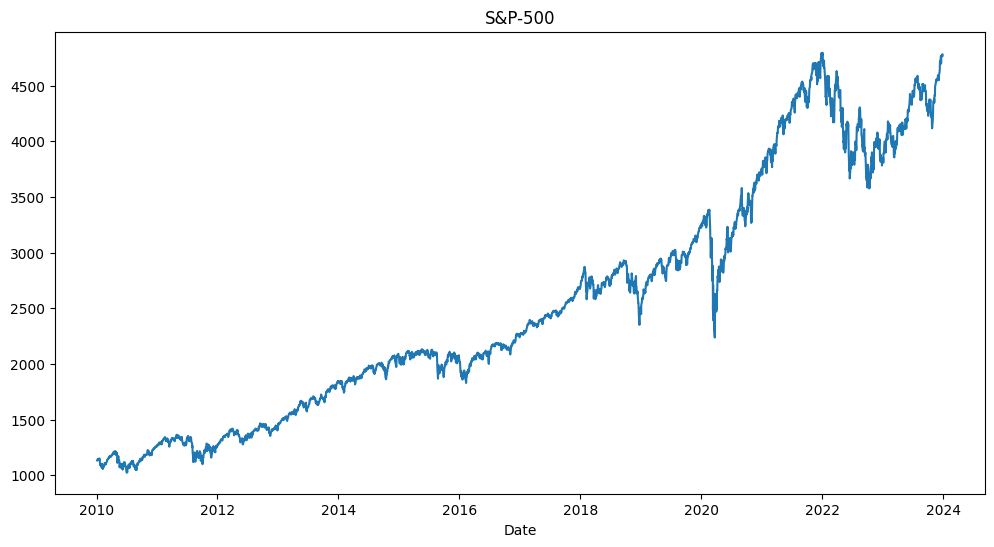

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(sp500.index,sp500['Adj Close'])
plt.title('S&P-500')
plt.xlabel('Date')
plt.show()

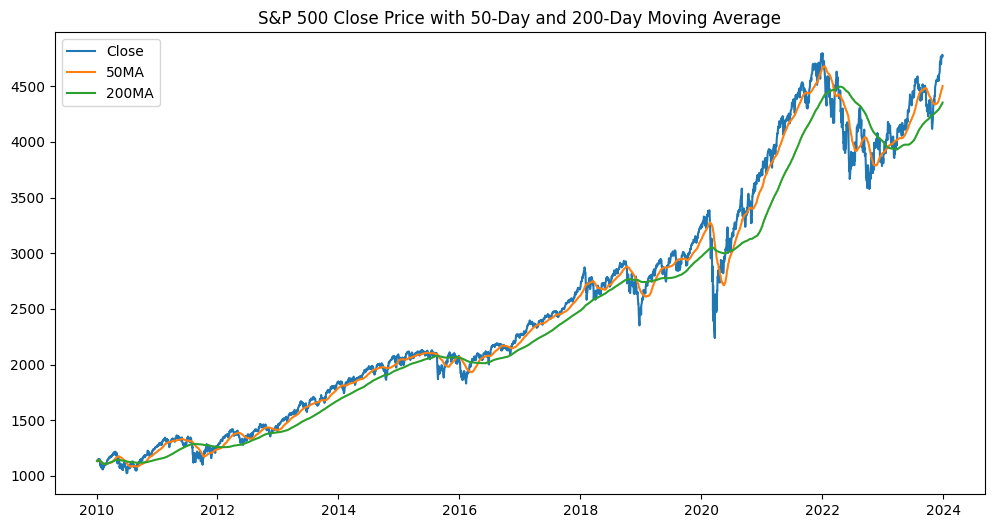

In [11]:
plt.figure(figsize=(12, 6))
plt.title('S&P 500 Close Price with 50-Day and 200-Day Moving Average')
plt.plot(sp500['Adj Close'])
plt.plot(sp500['50ma'])
plt.plot(sp500['200ma'])
plt.legend(['Close', '50MA', '200MA'])
plt.show()

**Calculating 1 Day and 10 Day returns**

In [12]:
returns_1D = 100*(sp500.pct_change()[1:]['Adj Close'])

returns_10D = 100*(sp500.pct_change(10)[10:]['Adj Close'])

In [13]:
returns_1D, returns_10D

(Date
 2010-01-05    0.311568
 2010-01-06    0.054552
 2010-01-07    0.400120
 2010-01-08    0.288173
 2010-01-11    0.174676
                 ...   
 2023-12-22    0.166006
 2023-12-26    0.423169
 2023-12-27    0.143046
 2023-12-28    0.037017
 2023-12-29   -0.282648
 Name: Adj Close, Length: 3521, dtype: float64,
 Date
 2010-01-19    1.521637
 2010-01-20    0.133743
 2010-01-21   -1.816842
 2010-01-22   -4.373336
 2010-01-25   -4.209676
                 ...   
 2023-12-22    3.263416
 2023-12-26    3.295014
 2023-12-27    2.969181
 2023-12-28    1.620115
 2023-12-29    1.065362
 Name: Adj Close, Length: 3512, dtype: float64)

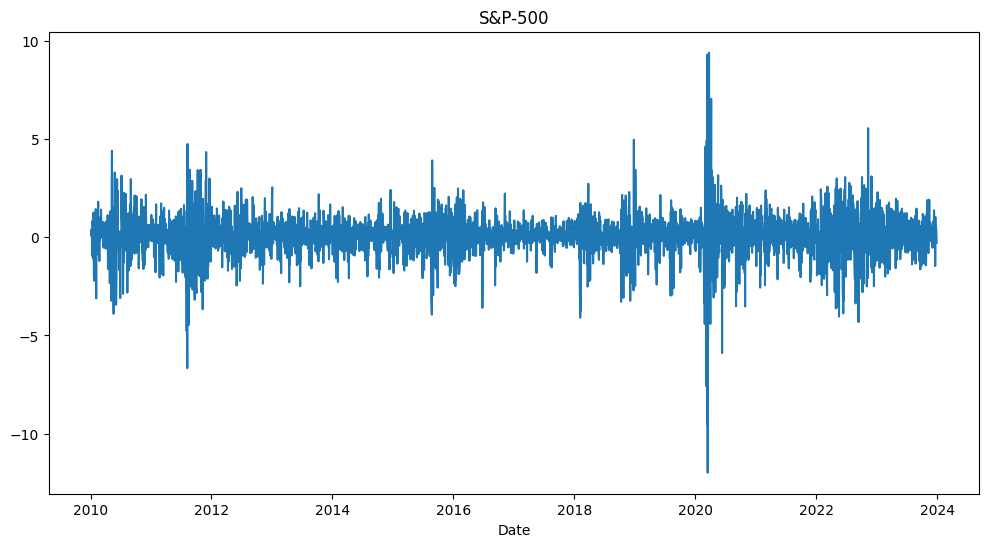

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(sp500.index[1:],returns_1D)
plt.title('S&P-500')
plt.xlabel('Date')
plt.show()

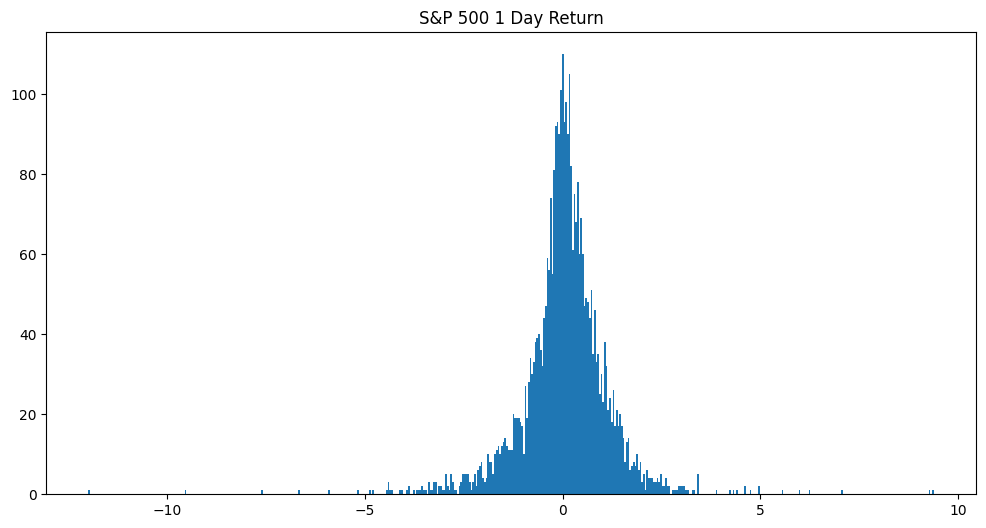

In [15]:
plt.figure(figsize=(12, 6))
plt.title('S&P 500 1 Day Return')
returns_1D.hist(bins=500, grid=False)
plt.show()

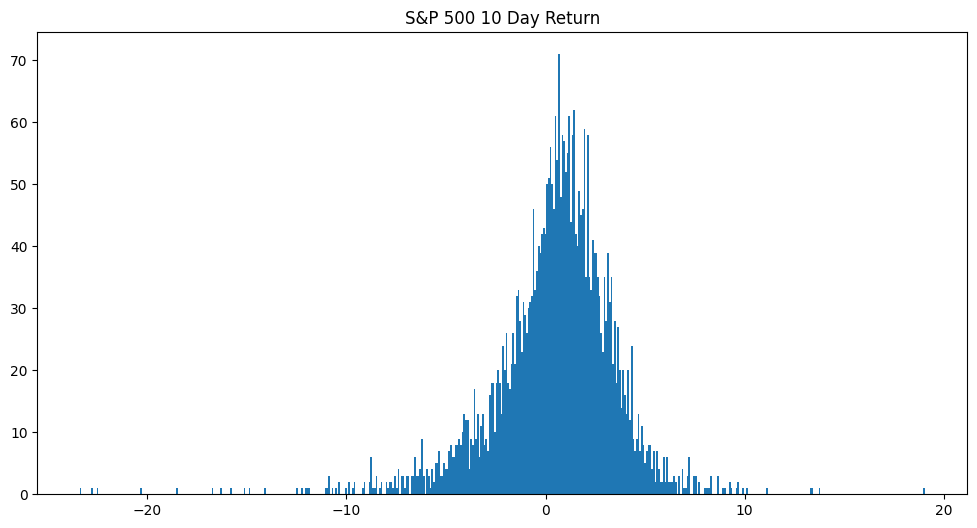

In [16]:
plt.figure(figsize=(12, 6))
plt.title('S&P 500 10 Day Return')
returns_10D.hist(bins=500, grid=False)
plt.show()

# **Volatility Estimation**

Volatility is the degree of variation of a trading price series over time, usually measured by the standard deviation. It is a measure of price fluctuation, indicates how much market index can change. Higher volatility implies greater risk, as prices may experience significant swings. This uncertainty has an impact on option prices. on the other hand, lower volatility signals more stable prices.

$σ=\sqrt{\frac{1}{n-1}\sum\limits_{n=1}^N(r_n-\mu)^2}$

where $r$ and $\mu$ are return and mean of return, and $n$ is number of observations.

In [17]:
realized_vol = returns_1D.rolling(10).std()[10:]
realized_vol

Date
2010-01-20    0.800214
2010-01-21    1.001813
2010-01-22    1.162245
2010-01-25    1.175387
2010-01-26    1.156686
                ...   
2023-12-22    0.748514
2023-12-26    0.748888
2023-12-27    0.749354
2023-12-28    0.649820
2023-12-29    0.663193
Name: Adj Close, Length: 3511, dtype: float64

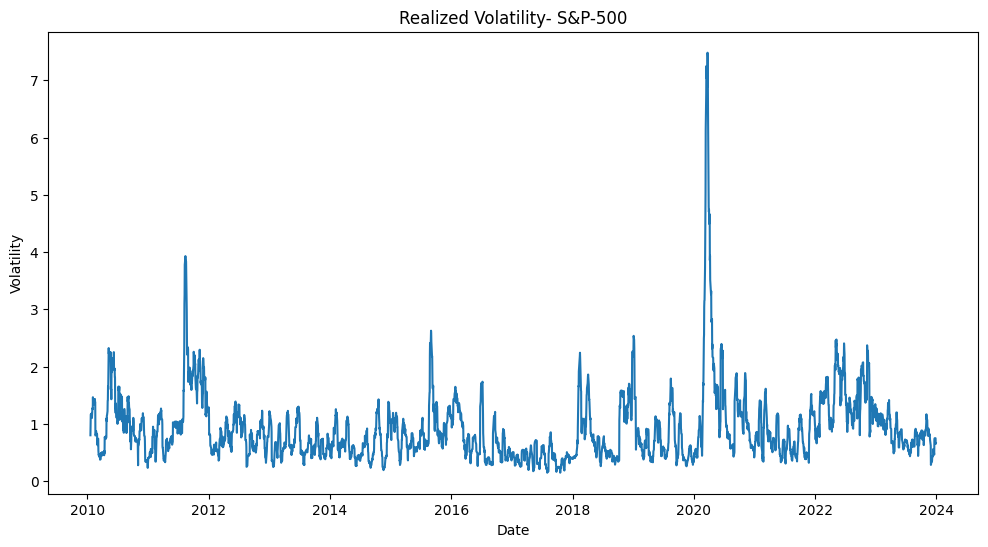

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(realized_vol.index,realized_vol)
plt.title('Realized Volatility- S&P-500')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

The figure shows the realized volatility of S&P 500 over the period of 2010–2023. The most striking observation is the spikes around the COVID-19 pandemic.


**Correlation between volatility and returns**

The objective is to quantify the relationship between the volatility of returns and the returns themselves for a given time series, such as the S&P 500 Index. This involves calculating and analyzing the correlation between these two variables to gain insights into their interdependence.

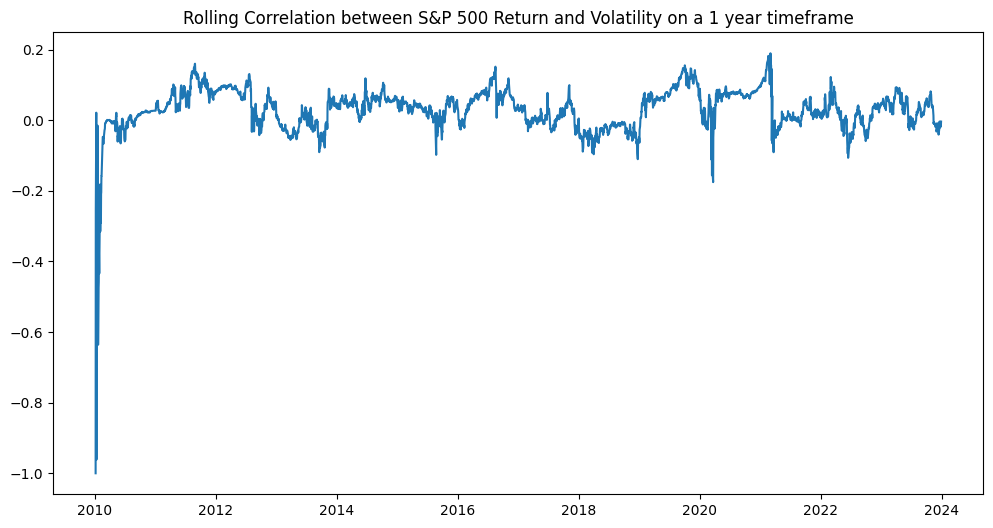

In [19]:
# Calculate the rolling correlation between the return and volatility
sp500['volatility'] = returns_1D.rolling(window=252,  min_periods=1).std() * math.sqrt(252)
sp500['corr252'] = returns_1D.rolling(window=252,  min_periods=1).corr(sp500['volatility'])

# Plot the rolling correlation
plt.figure(figsize=(12, 6))
plt.title('Rolling Correlation between S&P 500 Return and Volatility on a 1 year timeframe')
plt.plot(sp500['corr252'])
plt.show()

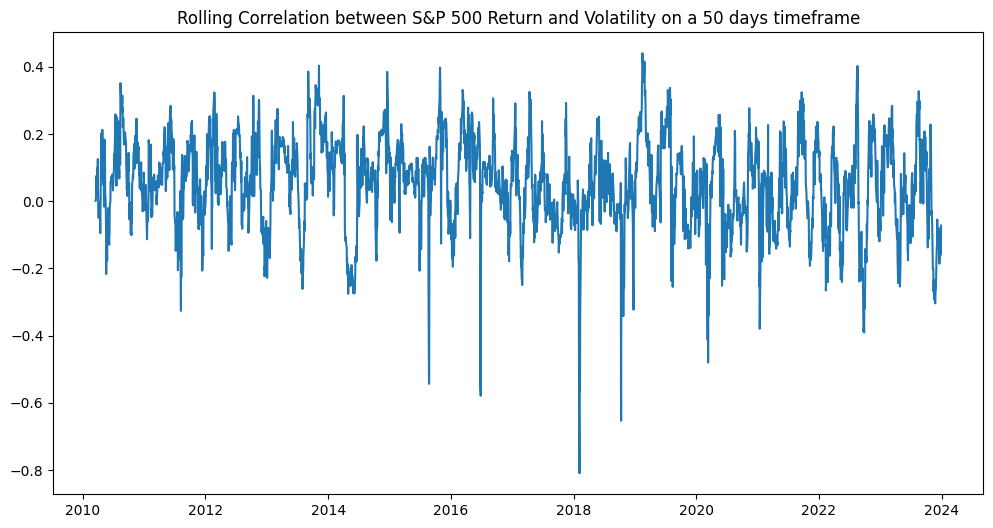

In [20]:
sp500['corr50'] = returns_1D.rolling(window=50).corr(sp500['volatility'])

# Plot the rolling correlation
plt.figure(figsize=(12, 6))
plt.title('Rolling Correlation between S&P 500 Return and Volatility on a 50 days timeframe')
plt.plot(sp500['corr50'])
plt.show()

ARCH and GARCH models are widely used in econometrics and finance to model and forecast time series data, particularly for stochastic volatility). These models are particularly useful for analyzing financial returns, where periods of high volatility can be followed by periods of low volatility and vice versa.

**ARCH Models**: Capture volatility clustering by modeling the conditional variance based on past squared errors only.

**GARCH Models**: Extend ARCH by also modeling the conditional variance based on past variances, making them more flexible and able to capture a wider range of volatility behaviors.

In [21]:
n = 252
split_date = returns_1D.iloc[-n:].index

# **ARCH**

The **ARCH** model is a univariate model and based on historical asset returns. The **ARCH($p$)** model has the following form:


The conditional variance $\sigma_t^2$ is modeled as:

$\sigma_t^2 = \omega + \sum\limits_{k=1}^p\alpha_k(r_{t-k})^2$

where the mean model is :

$r_t = \sigma_t \epsilon_t$

where $\epsilon_t$ is assumed to be normally distributed. In this parametric model, we need to satisfy some assumptions to have strictly positive variance. In this respect, the following conditions should hold:

In [22]:
arch = arch_model(returns_1D, mean='zero', vol='ARCH', p=1).fit(disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5022.05
Distribution:                  Normal   AIC:                           10048.1
Method:            Maximum Likelihood   BIC:                           10060.4
                                        No. Observations:                 3521
Date:                Sun, Sep 08 2024   Df Residuals:                     3521
Time:                        17:59:29   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.7558  4.528e-02     16.693  1.465e-62 [  0.667,  0.84

In [23]:
bic_arch = []

for p in range(1, 10):
    arch = arch_model(returns_1D, mean='zero', vol='ARCH', p=p).fit(disp='off')
    bic_arch.append(arch.bic)
    if arch.bic == np.min(bic_arch):
        best_param = p
arch = arch_model(returns_1D, mean='zero', vol='ARCH', p=best_param).fit(disp='off')
print("The optimal value of parameter p is {}".format(best_param))
print(arch.summary())
forecast = arch.forecast(start = split_date[0])
forecast_arch = forecast

The optimal value of parameter p is 9
                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4562.55
Distribution:                  Normal   AIC:                           9145.10
Method:            Maximum Likelihood   BIC:                           9206.77
                                        No. Observations:                 3521
Date:                Sun, Sep 08 2024   Df Residuals:                     3521
Time:                        17:59:30   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.206

In [24]:
rmse_arch = np.sqrt(mse(realized_vol[-n:] / 100,np.sqrt(forecast_arch.variance.iloc[-len(split_date):]/ 100)))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.0807


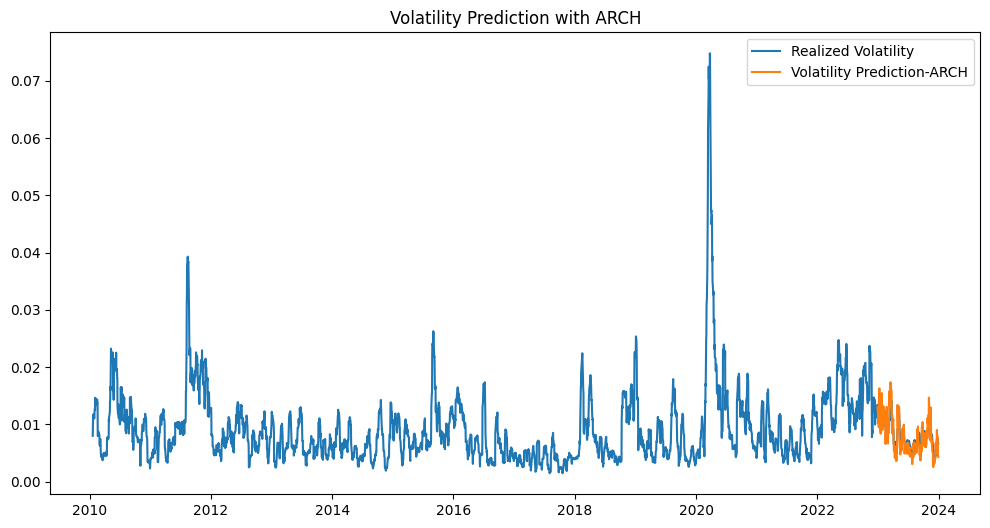

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100,label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()

In [26]:
current_realized_vol= realized_vol.iloc[-len(split_date):]

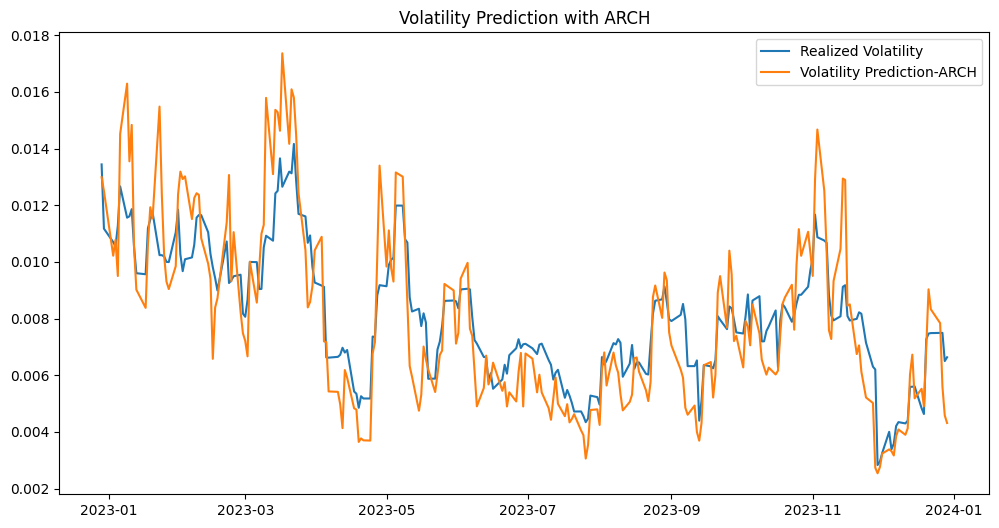

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(current_realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100,label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()

# **GARCH**

The **GARCH** model is an extension of the ARCH model incorporating lagged conditional variance. So ARCH is improved by adding $p$ number of delated conditional variance, which makes the GARCH model multivariate in the sense that it is an autoregressive moving average model for conditional variance with $p$ number of lagged squared returns and q number of lagged conditional variance. **GARCH($p$, $q$)** can be formulated as:

$\sigma_t^2 = \omega + \sum\limits_{k=1}^q\alpha_k(r_{t-k})^2 +\sum\limits_{k=1}^p\beta_k(\sigma_{t-k})^2$

In [28]:
garch = arch_model(returns_1D, mean='zero', vol='GARCH', p=1, o=0, q=1).fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4560.36
Distribution:                  Normal   AIC:                           9126.73
Method:            Maximum Likelihood   BIC:                           9145.23
                                        No. Observations:                 3521
Date:                Sun, Sep 08 2024   Df Residuals:                     3521
Time:                        17:59:31   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0348  7.480e-03      4.648  3.350e-06 [2.

In [29]:
bic_garch = []

for p in range(1, 10):
    for q in range(1, 10):
        garch = arch_model(returns_1D, mean='zero',vol='GARCH', p=p, o=0, q=q).fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch = arch_model(returns_1D, mean='zero', vol='GARCH',p=best_param[0], o=0, q=best_param[1]).fit(disp='off')
print("The optimal value of parameters are {} and {}".format(best_param[0],best_param[1]))
print(garch.summary())
forecast = garch.forecast(start=split_date[0])
forecast_garch = forecast

The optimal value of parameters are 1 and 1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4560.36
Distribution:                  Normal   AIC:                           9126.73
Method:            Maximum Likelihood   BIC:                           9145.23
                                        No. Observations:                 3521
Date:                Sun, Sep 08 2024   Df Residuals:                     3521
Time:                        17:59:43   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega         

In [30]:
rmse_arch = np.sqrt(mse(realized_vol[-n:] / 100,np.sqrt(forecast_garch.variance.iloc[-len(split_date):]/ 100)))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of GARCH model is 0.0800


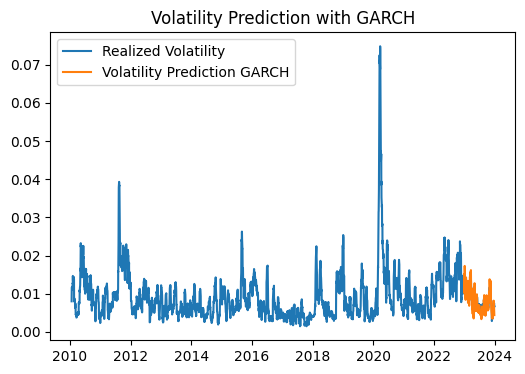

In [31]:
plt.figure(figsize=(6, 4))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100,label='Volatility Prediction GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()

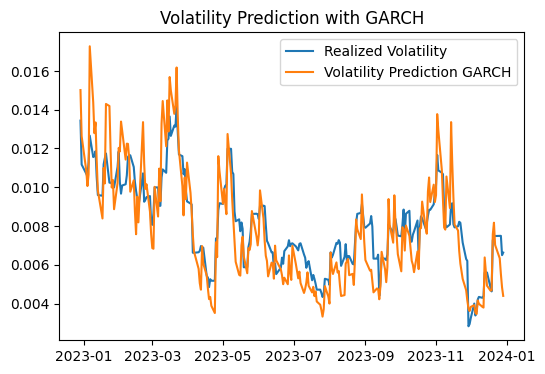

In [32]:
plt.figure(figsize=(6, 4))
plt.plot(current_realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100,label='Volatility Prediction GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()

# **Conclusion**

In this project, the **GARCH** (Generalized Autoregressive Conditional Heteroskedasticity) model has been demonstrated to be more effective than the **ARCH** (Autoregressive Conditional Heteroskedasticity) model for volatility prediction. GARCH improves upon ARCH by incorporating past conditional variances, which allows it to capture more complex volatility patterns and better account for volatility clustering. This additional flexibility makes GARCH a more robust tool for modeling time-varying volatility.

However, while GARCH offers significant advantages over ARCH, it is not without its limitations. Despite its improved flexibility, GARCH models can still be restrictive in capturing very complex volatility dynamics and may require careful tuning and parameter estimation. Moreover, GARCH models, like other parametric approaches, assume a specific functional form for volatility dynamics, which may not always align with the true underlying process. Consequently, while GARCH provides a better framework for volatility modeling compared to ARCH, it is essential to complement it with other approaches or enhancements for optimal accuracy in forecasting.